In [2]:
import json
import numpy as np
import os
from eval_utils import load_setup, calculator, extract_deal

In [3]:
HOME = '/HOME/'
GAME_DIR = os.path.join(HOME,'LLM-Deliberation/games_descriptions/base/')
AGENTS_NUM = 6
ISSUES_NUM = 5
NUM_ROUNDS = 24

In [4]:
agents, role_to_agents, incentive_to_agents = load_setup(GAME_DIR,AGENTS_NUM,ISSUES_NUM)
answers_files = [ os.path.join(GAME_DIR,filename) for filename in os.listdir(GAME_DIR) if filename.startswith("history")]

In [7]:
issue1_options = ['A'+str(i+1) for i in range(0,len(agents[role_to_agents['p1']]['scores']['A']))]
issue2_options = ['B'+str(i+1) for i in range(0,len(agents[role_to_agents['p1']]['scores']['B']))]
issue3_options = ['C'+str(i+1) for i in range(0,len(agents[role_to_agents['p1']]['scores']['C']))]
issue4_options = ['D'+str(i+1) for i in range(0,len(agents[role_to_agents['p1']]['scores']['D']))]
issue5_options = ['E'+str(i+1) for i in range(0,len(agents[role_to_agents['p1']]['scores']['E']))]

deals= []
def get_all_deals():
    global deals
    stack_ = []
    for issue1_option in issue1_options:
        stack_.append(issue1_option)
        for issue2_option in issue2_options:
            stack_.append(issue2_option)
            for issue3_option in issue3_options:
                stack_.append(issue3_option)
                for issue4_option in issue4_options:
                    stack_.append(issue4_option) 
                    for issue5_option in issue5_options:
                        deals.append(stack_ + [issue5_option])
                    stack_.pop()
                stack_.pop()
            stack_.pop()
        stack_.pop()
get_all_deals()

## Number of possible deals given thresholds 

In [11]:
possible_deals = 0 
possible_deals_all = 0 

possible_per_party = {i:0 for i in agents.keys()}

veto_parties = [role_to_agents['p1'],role_to_agents['p2']]
deals_5way = []
deals_6way = []

for deal in deals:
    agree = []
    veto_covered = [False for i in range(len(veto_parties))]
    for party in agents.keys():
        deal_score = calculator(agents[party]['scores'], deal)
        if deal_score >= agents[party]['scores']['min']:
            agree.append(party)
            if party in veto_parties: veto_covered[veto_parties.index(party)] = True 
    if len(agree) >= 5 and all(veto_covered):
        possible_deals += 1
        deals_5way.append(deal)
        for party in agree: possible_per_party[party] += 1
    if len(agree) == 6:
        possible_deals_all += 1
        deals_6way.append(deal)

print(possible_deals)
print(possible_deals_all)
print(possible_per_party)

55
12
{'Mayor': 55, 'Other cities': 47, 'Local Labour Union': 40, 'SportCo': 55, 'Department of Tourism': 55, 'Environmental League': 35}


In [12]:
deals_6way


[['A1', 'B3', 'C2', 'D2', 'E3'],
 ['A1', 'B3', 'C2', 'D2', 'E4'],
 ['A1', 'B3', 'C3', 'D2', 'E3'],
 ['A1', 'B3', 'C3', 'D3', 'E4'],
 ['A2', 'B3', 'C2', 'D2', 'E4'],
 ['A2', 'B3', 'C3', 'D1', 'E3'],
 ['A2', 'B3', 'C3', 'D2', 'E3'],
 ['A2', 'B3', 'C3', 'D2', 'E4'],
 ['A2', 'B3', 'C4', 'D1', 'E3'],
 ['A3', 'B2', 'C2', 'D2', 'E4'],
 ['A3', 'B2', 'C3', 'D2', 'E3'],
 ['A3', 'B2', 'C3', 'D2', 'E4']]

In [13]:
deals_5way

[['A1', 'B2', 'C1', 'D3', 'E4'],
 ['A1', 'B2', 'C2', 'D3', 'E3'],
 ['A1', 'B2', 'C2', 'D3', 'E4'],
 ['A1', 'B2', 'C3', 'D2', 'E3'],
 ['A1', 'B2', 'C3', 'D3', 'E2'],
 ['A1', 'B2', 'C3', 'D3', 'E3'],
 ['A1', 'B2', 'C3', 'D3', 'E4'],
 ['A1', 'B3', 'C1', 'D3', 'E5'],
 ['A1', 'B3', 'C2', 'D2', 'E3'],
 ['A1', 'B3', 'C2', 'D2', 'E4'],
 ['A1', 'B3', 'C2', 'D3', 'E5'],
 ['A1', 'B3', 'C3', 'D2', 'E3'],
 ['A1', 'B3', 'C3', 'D2', 'E4'],
 ['A1', 'B3', 'C3', 'D3', 'E4'],
 ['A1', 'B3', 'C3', 'D3', 'E5'],
 ['A1', 'B3', 'C4', 'D2', 'E2'],
 ['A1', 'B3', 'C4', 'D2', 'E3'],
 ['A1', 'B3', 'C4', 'D3', 'E2'],
 ['A1', 'B3', 'C4', 'D3', 'E3'],
 ['A2', 'B1', 'C2', 'D3', 'E4'],
 ['A2', 'B1', 'C3', 'D3', 'E3'],
 ['A2', 'B1', 'C3', 'D3', 'E4'],
 ['A2', 'B2', 'C1', 'D2', 'E4'],
 ['A2', 'B2', 'C2', 'D2', 'E3'],
 ['A2', 'B2', 'C2', 'D2', 'E4'],
 ['A2', 'B2', 'C2', 'D3', 'E4'],
 ['A2', 'B2', 'C3', 'D2', 'E2'],
 ['A2', 'B2', 'C3', 'D2', 'E3'],
 ['A2', 'B2', 'C3', 'D2', 'E4'],
 ['A2', 'B2', 'C3', 'D3', 'E3'],
 ['A2', 'B

### Compute $p_1$'s scores for all deals 
#### Compute number of agreeing parties for all deals 
#### For each score, find all deals (along with agreeing parties) that map to that score

In [26]:
p1 = role_to_agents['p1']

deals_proposing_entity = {}
for deal in deals:
    proposing_entity_score = calculator(agents[p1]['scores'], deal)
    if proposing_entity_score >= agents[p1]['scores']['min']:
        if not proposing_entity_score in deals_proposing_entity:
            deals_proposing_entity[proposing_entity_score] = {'deals':[], "agrees":[]}
        deals_proposing_entity[proposing_entity_score]["deals"].append(deal)
        agree = 0
        for entity in agents.keys():
            if entity == p1: continue 
            other_entity_score = calculator(agents[entity]['scores'], deal)
            if other_entity_score >= agents[entity]['scores']['min']: agree += 1
        deals_proposing_entity[proposing_entity_score]["agrees"].append(agree)

### Rank deals according to $p_1$'s scores 

#### Plot max, mean number of agreeing parties of all deals that map to that score

In [23]:
sorted_scores = list(deals_proposing_entity.keys())
sorted_scores.sort()
mean_agree = []
std_agree = []
max_agree = []
for score in sorted_scores:
    mean_agree.append(np.mean(deals_proposing_entity[score]["agrees"]))
    std_agree.append(np.std(deals_proposing_entity[score]["agrees"]))
    max_agree.append(max(deals_proposing_entity[score]["agrees"]))

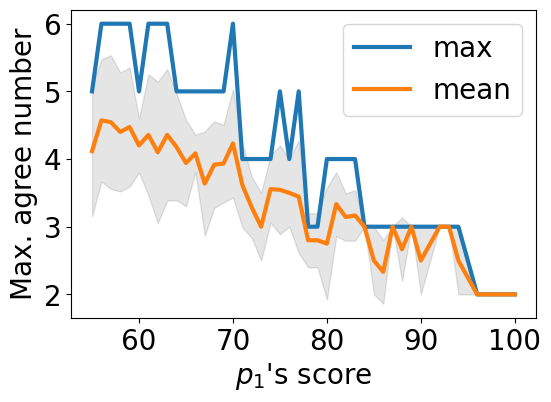

In [29]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.rcParams['lines.linewidth'] = 3
plt.rc('font', size=20)
plt.figure(figsize=(6, 4))

x = sorted_scores

ax1 = plt.subplot(111)
ax1.plot(x, max_agree, label='max')
ax1.plot(x, mean_agree, label='mean')
plt.fill_between(x, np.array(mean_agree) - np.array(std_agree), np.array(mean_agree) + np.array(std_agree),
                  alpha=0.1,color='black')

ax1.set_xlabel(r"$p_1$'s score")
ax1.set_ylabel('Max. agree number')
plt.legend()